## 🧠 Alzheimer's Disease Classification
## The data in total consists of 6400 images.

## Using Enhanced CNN Models namely,
## * Inception Net (V3)
## * Resnet 50

### Libraries

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

## Inception net V3 Model

### Data Pre-Processing

In [ ]:
base_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

In [ ]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

### Performing Image Augmentation to have more data samples

In [ ]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

### Data Visualization

In [ ]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

### Retrieving the data from the ImageDataGenerator iterator

In [ ]:
train_data, train_labels = train_data_gen.next()
print(train_data.shape, train_labels.shape)

### Performing over-sampling of the data, since the classes are imbalanced

In [ ]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

### Splitting the data into train, test, and validation sets

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Using the InceptionV3 model as a base model for the task

In [ ]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

### Freezing the pretrained layers for further training

In [ ]:
for layer in inception_model.layers:
    layer.trainable=False

### Further Model Building

In [ ]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

### Defining a custom callback function to stop training our model when accuracy goes above 99%

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [ ]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]
    
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

### Fitting the Model

In [ ]:
EPOCHS = 20
history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

### Tabulating the Results of our custom InceptionV3 model
### Plotting the trend of the metrics during training

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
test_scores = custom_inception_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

### Predicting the test data

In [ ]:
pred_labels = custom_inception_model.predict(test_data)

### Print the classification report of the tested data

In [ ]:
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

### Plot the confusion matrix to understand the classification in detail

In [ ]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

## RESNET 50 Model

### Loading Dataset

In [ ]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     


train_dataset = image_generator.flow_from_directory(batch_size=16,
                                                 directory='/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                 shuffle=True,
                                                 target_size=(224,224), 
                                                 subset="training",
                                                 class_mode='categorical')
image_generator = ImageDataGenerator(rescale=1/255,validation_split=0.2) 
validation_dataset = image_generator.flow_from_directory(batch_size=16,
                                                 directory='/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                 shuffle=True,
                                                 target_size=(224,224),
                                                 class_mode='categorical')


submission = image_generator.flow_from_directory(
                                                 directory='/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                 shuffle=False,
                                                subset="validation",
                                                 target_size=(224,224), 
                                                 class_mode='categorical')

### Data and label visualization

In [ ]:
batch_1_img = train_dataset[0]
for i in range(0,2):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()

### Using Transfer Learning importing the pretrained model and Fitting the model (RESNET 50)

In [ ]:
rn = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in rn.layers:
    layer.trainable = False
x = Flatten()(rn.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=rn.input, outputs=prediction)

modelvgg.compile(optimizer='adam',
loss=tf.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

modelvgg.fit(train_dataset, epochs=20, validation_data=validation_dataset, callbacks=callback)

## Sort

In [20]:
def sortit(x,y):
    n = len(x)
    for i in range(n-1):
        for j in range(n - i - 1):
            if x[j] > x[j+1]:
                x[j],x[j+1] = x[j+1],x[j]
                y[j],y[j+1] = y[j+1],y[j]
    return x,y

### Model's Accuracy (Validation Set)

In [ ]:
accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", accuracy[0])
print("Accuracy: ", accuracy[1])

### Model's Accuracy (Test Set)

In [ ]:
accuracy = modelvgg.evaluate(submission)
print("Loss: ", accuracy[0])
print("Accuracy: ", accuracy[1])

## Compiling Accuracies of all the previously applied models

In [ ]:
import plotly.graph_objects as go

schools = ["SVM", "KNN", "ANN", "CNN", "MobileNet", "MobileNetV2",
           "VGG16", "VGG19", "DensetNet121", "DensetNet169", "ResNet50",
           "InceptionNetV3"]

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=[68, 41, 75.01, 90, 79.35, 78.47, 99.29, 90.51, 93.67, 88.71, 88.97, 89],
    y=schools,
    marker=dict(color="crimson", size=12),
    mode="markers",
    name="Accuracy",
))

fig.add_trace(go.Scatter(
    x=[0.30,0.19,0.5001,0.8997,0.46,0.47,0.0727,0.867,0.94,1.039,0.9890,0],
    y=schools,
    marker=dict(color="gold", size=12),
    mode="markers",
    name="F1 Score/Loss Function",
))

fig.update_layout(title="Alzheimer Disease Detection",
                  xaxis_title="Accuracy (in %,Red) & F1 Score/Loss Val (Yellow)",
                  yaxis_title="Model Applied")

fig.show()

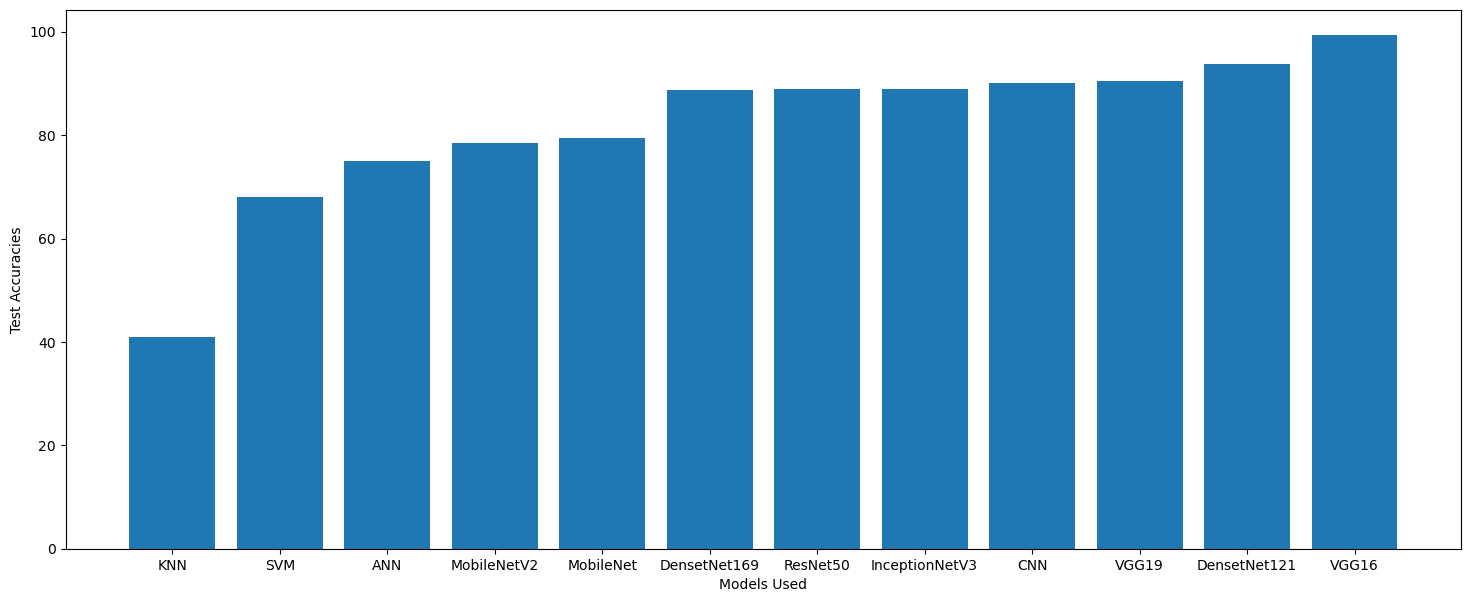

In [21]:
fig = plt.figure(figsize =(18, 7))
y = ["SVM", "KNN", "ANN", "CNN", "MobileNet", "MobileNetV2",
           "VGG16", "VGG19", "DensetNet121", "DensetNet169", "ResNet50",
           "InceptionNetV3"]
x=[68, 41, 75.01, 90, 79.35, 78.47, 99.29, 90.51, 93.67, 88.71, 88.97, 89]
x,y = sortit(x,y)
# Horizontal Bar Plot
plt.bar(y,x)
plt.ylabel("Test Accuracies")
plt.xlabel("Models Used")
# Show Plot
plt.show()

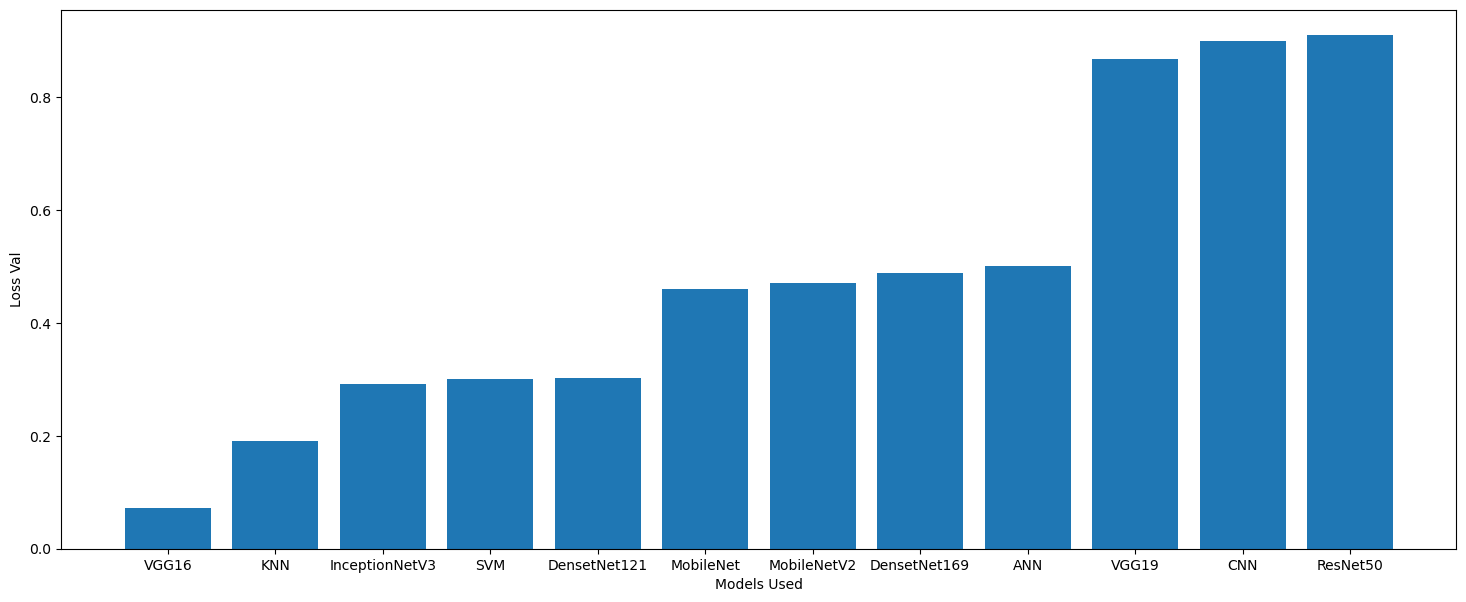

In [22]:
fig = plt.figure(figsize =(18, 7))
y = ["SVM", "KNN", "ANN", "CNN", "MobileNet", "MobileNetV2",
           "VGG16", "VGG19", "DensetNet121", "DensetNet169", "ResNet50",
           "InceptionNetV3"]
x=[0.30,0.19,0.5001,0.8997,0.46,0.47,0.0727,0.867,0.3026,0.4890,0.9094,0.2919]
# Horizontal Bar Plot
x,y = sortit(x,y)
plt.bar(y,x)
plt.ylabel("Loss Val")
plt.xlabel("Models Used")
 
# Show Plot
plt.show()